In [1]:
# Set the experiment name to be something meaningful. 
# It will be part of the name of the model to be saved.
EXPERIMENT_NAME = "[HashNet-100-iteration-dropout-80]"
DEBUG = True        # Set to True if you want to see outputs used for debugging 
verbose = False      # Set to True if you want to see the loss function per epoch in real time

In [2]:
from IPython.display import SVG

import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, Model
from keras.layers.core import Activation, Flatten, Dense, Dropout
from keras.layers.convolutional import Convolution2D, MaxPooling2D, ZeroPadding2D
from keras.layers import Input, Concatenate, Layer, GaussianNoise
from keras.applications import vgg19
from keras.utils import plot_model
from keras.optimizers import RMSprop, Adam
from keras import backend as K
from keras.utils.vis_utils import model_to_dot

import sys
import datetime
import keras
import pickle
import logging
import h5py
import numpy as np
import librosa
import matplotlib.pyplot as plt
from scipy import ndimage
import scipy.io

from songdb import data_dict
from preprocess import preprocess
from model import build_model

%matplotlib inline

/home/mjenrungrot/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)
/home/mjenrungrot/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
logger = logging.getLogger()

# File Handler
fhandler = logging.FileHandler(filename='{:}.log'.format(EXPERIMENT_NAME), mode='w')
formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')
fhandler.setFormatter(formatter)
logger.addHandler(fhandler)

# Output stream Handler
ch = logging.StreamHandler(sys.stdout)
ch.setFormatter(formatter)
logger.addHandler(ch)

if DEBUG: 
    logger.setLevel(logging.DEBUG)
    ch.setLevel(logging.DEBUG)
else:     
    logger.setLeveL(logging.INFO)
    ch.setLevel(logging.INFO)

## Config Keras

In this code, we will use tensorflow backend on Keras because it's relatively faster than Theano. We'll use the image data format in the form of `(n_channel, width, height)`. Please look at the Keras documentation for more details.

In [4]:
assert K.backend() == 'tensorflow'
logger.debug("Keras backend is tensorflow.")

K.set_image_data_format('channels_first')
assert K.image_data_format() == 'channels_first'
logger.debug("Keras image data format is channels_first")

2018-03-07 01:16:34,928 - root - DEBUG - Keras backend is tensorflow.
2018-03-07 01:16:34,929 - root - DEBUG - Keras image data format is channels_first


## Load dataset
We load the pair-annotation dataset. Here, we generate an array of of shapes `(n_pairs, 2, 76, 121)`.

In [5]:
logger.debug("Load Paired-annotation data")
data = data_dict()
logger.debug("\t data.type = {:}".format(type(data)))
logger.debug("\t data = {:}".format(data))
ref_query_pairs = data['taylorswift']

songPairs = []
totalPairs = 0 
for ref, query in ref_query_pairs:
    # Get pairs for each ref + query
    curr_pairs = []
    for i in range(ref.shape[0]):
        refQ = preprocess(librosa.cqt(np.asfarray(ref[i], dtype='float32'), sr = 22050, fmin=130.81, n_bins=121, bins_per_octave=24, hop_length=96), 3).T
        queryQ = preprocess(librosa.cqt(np.asfarray(query[i], dtype='float32'), sr = 22050, fmin=130.81, n_bins=121, bins_per_octave=24, hop_length=96), 3).T
        Q_pair = np.append(np.array([refQ]), np.array([queryQ]), axis=0)[np.newaxis, :]
        curr_pairs.append(Q_pair)
    curr_pairs = np.vstack(tuple(curr_pairs))
    totalPairs += curr_pairs.shape[0]
    songPairs.append(curr_pairs)
    logger.debug("Song {:}: Finish current pairs with shape = {:}".format(len(songPairs), curr_pairs.shape))
    logger.debug("Number of samples for the current song: {:}".format(len(curr_pairs)))

logger.debug("There are {:} number of pairs".format(totalPairs))

2018-03-07 01:16:34,984 - root - DEBUG - Load Paired-annotation data
2018-03-07 01:16:34,985 - root - DEBUG - 	 data.type = <class 'dict'>
2018-03-07 01:16:34,987 - root - DEBUG - 	 data = {'taylorswift': <generator object get_ref_query_pairs at 0x7f80b811be60>}


/home/mjenrungrot/anaconda3/lib/python3.6/site-packages/librosa/util/utils.py:1725: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if np.issubdtype(x.dtype, float) or np.issubdtype(x.dtype, complex):
/home/mjenrungrot/anaconda3/lib/python3.6/site-packages/librosa/util/utils.py:1725: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  if np.issubdtype(x.dtype, float) or np.issubdtype(x.dtype, complex):
/home/mjenrungrot/anaconda3/lib/python3.6/site-packages/librosa/util/utils.py:1725: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if np.issubdtype(x.dtype, float) or np.issubdtype(x.d

2018-03-07 01:16:55,226 - root - DEBUG - Song 1: Finish current pairs with shape = (272, 2, 76, 121)
2018-03-07 01:16:55,230 - root - DEBUG - Number of samples for the current song: 272
2018-03-07 01:17:14,627 - root - DEBUG - Song 2: Finish current pairs with shape = (264, 2, 76, 121)
2018-03-07 01:17:14,629 - root - DEBUG - Number of samples for the current song: 264
2018-03-07 01:17:22,164 - root - DEBUG - Song 3: Finish current pairs with shape = (100, 2, 76, 121)
2018-03-07 01:17:22,166 - root - DEBUG - Number of samples for the current song: 100
2018-03-07 01:17:29,599 - root - DEBUG - Song 4: Finish current pairs with shape = (100, 2, 76, 121)
2018-03-07 01:17:29,601 - root - DEBUG - Number of samples for the current song: 100
2018-03-07 01:17:45,950 - root - DEBUG - Song 5: Finish current pairs with shape = (221, 2, 76, 121)
2018-03-07 01:17:45,952 - root - DEBUG - Number of samples for the current song: 221
2018-03-07 01:18:04,732 - root - DEBUG - Song 6: Finish current pairs 

In [6]:
p_train = .6
cutOffIdx = 0
currentNumberOfPairs = 0
for song in songPairs:
    currentNumberOfPairs += song.shape[0]
    cutOffIdx += 1
    if currentNumberOfPairs >= totalPairs * p_train:
        break

data_train = tuple(songPairs[:cutOffIdx])
data_val = tuple(songPairs[cutOffIdx:])
logger.debug("Finish loading paired-annotation data")
logger.debug("=> There are {:} songs for training [{:.2f} percent]".format(len(data_train), (currentNumberOfPairs/totalPairs * 100.0)))
logger.debug("=> There are {:} songs for validation".format(len(data_val)))

2018-03-07 01:18:36,234 - root - DEBUG - Finish loading paired-annotation data
2018-03-07 01:18:36,236 - root - DEBUG - => There are 6 songs for training [74.05 percent]
2018-03-07 01:18:36,237 - root - DEBUG - => There are 2 songs for validation


## Preprocessing
Obtain a matrix $X_1$, $X_2$, $[w_{ij}]$, and $[s_{ij}]$ where $X_1$ and $X_2$ are pairs of images of shape 
`(n_samples, 1, width, height)`; $[w_{ij}]$ is the weight vector of shape `(n_samples, 1)` which describes the weight of each pair; and $[s_{ij}]$ is a binary vector of shape `(n_samples,1)` indicating whether inputs $i$ and $j$ are the same.

__Add similar pairs__

We add similar pairs based on the dataset we have.

__Add non-similar pairs__

We add non-similar pairs by randomly selecting two CQT frames from the dataset. Note that we say two CQT pairs are not similar when they come from different songs only.

__Data Post-processing__

Convert $X_1$, $X_2$, $[s_{ij}]$ in to numpy arrays.

__Calculate weights__

Calculate the weight vector $[w_{ij}]$. The term $w_{ij}$ is defined as 

$$
    w_{ij} = \begin{cases}
    \frac{|S|}{|S_{1}|} &\text{if $x^{(i)}$ is similar to $x^{(j)}$}\\
    \frac{|S|}{|S_{0}|} &\text{if $x^{(i)}$ is not similar to $x^{(j)}$}
    \end{cases}
$$

In [7]:
def generate_training_data(data, nNonSimilar=1000):
#     nPairs = data.shape[0] 
    X1 = []
    X2 = []
    S = []
    groundTruth = []
    
    # add similar pairs
    for songId in range(len(data)):
        nPairs = data[songId].shape[0]
        for idx in range(nPairs):
            X1.append(np.expand_dims(data[songId][idx][0][:][:], axis=0))
            X2.append(np.expand_dims(data[songId][idx][1][:][:], axis=0))
            groundTruth.append(((songId,idx),(songId,idx)))
            S.append(True)
        
    # add non-similar pairs
    for i in range(nNonSimilar):
        [songId1, songId2] = np.random.choice(len(data), 2, replace=False)
        nPairs1 = data[songId1].shape[0]
        nPairs2 = data[songId2].shape[0]

        [idx1] = np.random.choice(nPairs1, 1)
        [idx2] = np.random.choice(nPairs2, 1)
        X1.append(np.expand_dims(data[songId1][idx1][0][:][:], axis=0))
        X2.append(np.expand_dims(data[songId2][idx2][1][:][:], axis=0))
        S.append((songId1,idx1) == (songId2,idx2))
        groundTruth.append(((songId1,idx1),(songId2,idx2)))
        
    # post-processing
    X1 = np.array(X1)
    X2 = np.array(X2)
    S = np.array(S).reshape(-1,1)
    # calculate weights
    n_sim = len(S[S==True])
    w_sim   = len(X1) / n_sim             # w_ij for similar pairs
    w_insim = len(X1) / (len(X1) - n_sim)  # w_ij for dissimilar pairs
    W = S*w_sim + (~S)*w_insim          # w vector for pairs
    S = S.astype('float32')
    
    logger.debug("X1 shape: {:}".format(X1.shape))
    logger.debug("X2 shape: {:}".format(X2.shape))
    logger.debug("S shape: {:}".format(S.shape))
    logger.debug("W shape: {:}".format(W.shape))
    logger.debug("There are {:} out of {:} pairs that are similar [{:.2f} percent]".format(n_sim, 
                                                                                           len(X1),
                                                                                           100.0*n_sim/len(X1)))
    
    return X1, X2, S, W, groundTruth

In [8]:
X1, X2, S, W, groundTruth = generate_training_data(data_train)
X1_val, X2_val, S_val, W_val, groundTruth_val = generate_training_data(data_val)

2018-03-07 01:18:36,647 - root - DEBUG - X1 shape: (2210, 1, 76, 121)
2018-03-07 01:18:36,649 - root - DEBUG - X2 shape: (2210, 1, 76, 121)
2018-03-07 01:18:36,650 - root - DEBUG - S shape: (2210, 1)
2018-03-07 01:18:36,651 - root - DEBUG - W shape: (2210, 1)
2018-03-07 01:18:36,652 - root - DEBUG - There are 1210 out of 2210 pairs that are similar [54.75 percent]
2018-03-07 01:18:36,833 - root - DEBUG - X1 shape: (1424, 1, 76, 121)
2018-03-07 01:18:36,834 - root - DEBUG - X2 shape: (1424, 1, 76, 121)
2018-03-07 01:18:36,835 - root - DEBUG - S shape: (1424, 1)
2018-03-07 01:18:36,836 - root - DEBUG - W shape: (1424, 1)
2018-03-07 01:18:36,837 - root - DEBUG - There are 424 out of 1424 pairs that are similar [29.78 percent]


In [9]:
nPairs = X1.shape[0]

## Model

__Define inputs__

Create a HashNet model with four inputs: two images tensors, similarity vector, and weight vector.

In [10]:
width = 76
height = 121
n_channel = 1

In [11]:
image_a    = Input(shape=(n_channel, width, height), name='image_1')
image_b    = Input(shape=(n_channel, width, height), name='image_2')
similarity = Input(shape=(1,), name="similarity")
weight     = Input(shape=(1,), name="weight")

__Pre-trained model__

Use a pre-trained model here to obtain intermediate values from the pre-trained model. We call this pre-trained model by `base_model`. The `base_model` is generally used to convert a CQT image to some representation.

In [12]:
model_path = '/data1/mint/public/taylorswift_out/model.mat'
model = scipy.io.loadmat(model_path)
logger.debug("Load model from {:}".format(model_path))
evecs = np.array(model['eigvecs']).T

2018-03-07 01:18:37,262 - root - DEBUG - Load model from /data1/mint/public/taylorswift_out/model.mat


In [13]:
m = 20
pca_matrix = np.array([vec.reshape((m, -1)) for vec in evecs])
delta = 4
base_model = build_model(pca_matrix, refQ.shape, delta=delta, compute_delta=True)
logger.debug("Construct base model")

2018-03-07 01:18:39,495 - root - DEBUG - Construct base model


In [14]:
# pop last layer
lastLayer = base_model.layers[-1]
base_model.pop()

# add dropout
base_model.add(Dropout(0.8)) # Drop 70%

# add back the last layer
base_model.add(lastLayer)

2018-03-07 01:18:39,743 - root - DEBUG - Save base_model architecture to base_model.png


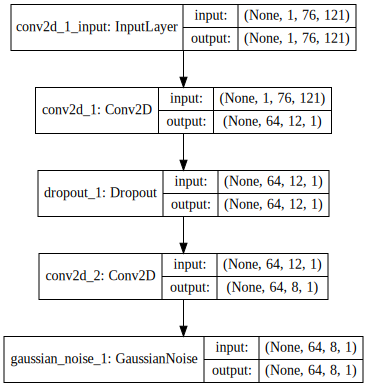

In [15]:
plot_model(base_model, show_shapes=True, to_file='base_model.png')
logger.debug("Save base_model architecture to base_model.png")
SVG(model_to_dot(base_model, show_shapes=True).create(prog='dot', format='svg'))

__Obtain intermediate values__

Intermediate values are values directly after the base model.

In [16]:
# Obtain intermediate tensor
intermediate_a = base_model(image_a)
intermediate_b = base_model(image_b)

# Flatten the layer
flatten_a = Flatten()(intermediate_a)
flatten_b = Flatten()(intermediate_b)

__Append a layer for binary encoding__

This layer has a `tanh` activation defined in the same way as HashNet paper. Note that initial beta value, number of bits, and `alpha` in the block below are hyperparameters.

In [17]:
beta         = 1            # Initial beta value
numberOfBits = None
alpha        = 0.05         # Set to be something small because it prevents the loss function from blowing up.
logger.debug("[HashNet Model] beta = {:}, numberOfBits = {:}, alpha = {:}".format(beta, numberOfBits, alpha))

2018-03-07 01:18:40,193 - root - DEBUG - [HashNet Model] beta = 1, numberOfBits = None, alpha = 0.05


In [18]:
def custom_activation(x):
    """
    Our own defined activation function
    """
    global beta
    return K.tanh(beta * x)

In [19]:
class CustomizedLossLayer(Layer):
    """
    Our own defined layer for keeping track of loss function
    """
    
    def __init__(self, **kwargs):
        self.is_placeholder = True
        super(CustomizedLossLayer, self).__init__(**kwargs)
    
    def my_loss(self, encoded_a, encoded_b, similarity, weight):
        global alpha
        x = encoded_a
        y = encoded_b
        dot_product = K.sum(x * y, axis=-1, keepdims=True)
        logger.debug(dot_product)
        return K.sum(weight * (K.log(1 + K.exp(alpha * dot_product)) - alpha * similarity * dot_product))
    
    def call(self, inputs):
        encoded_a = inputs[0]
        encoded_b = inputs[1]
        similarity = inputs[2]
        weight = inputs[3]
        loss = self.my_loss(encoded_a, encoded_b, similarity, weight)
        self.add_loss(loss, inputs=inputs)
        return K.ones_like(similarity)


In [20]:
activation_layer = Activation(custom_activation)
encoded_a = activation_layer(flatten_a)
encoded_b = activation_layer(flatten_b)

__Create a model for training__

We construct a model using 2 representations derived by the same base model and similarity and weight. The architecture of the model is given below.

In [21]:
# Define a loss layer with 4 inputs
loss = CustomizedLossLayer()([encoded_a, encoded_b, similarity, weight])

2018-03-07 01:18:40,265 - root - DEBUG - Tensor("customized_loss_layer_1/Sum:0", shape=(?, 1), dtype=float32)


In [22]:
# Define a model that has 4 inputs and outputs loss
model = Model(inputs=[image_a, image_b, similarity, weight], outputs=[loss])

In [23]:
# Compile the model with our own defined loss function.
# Note that loss function is already defined in a layer, so
# `zero_loss` here doesn't actually do anything.

def zero_loss(y_true, y_pred):
    return K.zeros_like(y_pred)

logger.debug("Use Adam optimizer with lr = 1e-5")
adam = Adam(lr=1e-5)
model.compile(optimizer=adam, loss=zero_loss)

2018-03-07 01:18:40,297 - root - DEBUG - Use Adam optimizer with lr = 1e-5


__Visualize model architecture__

2018-03-07 01:18:40,549 - root - DEBUG - Save model architecture to model.png


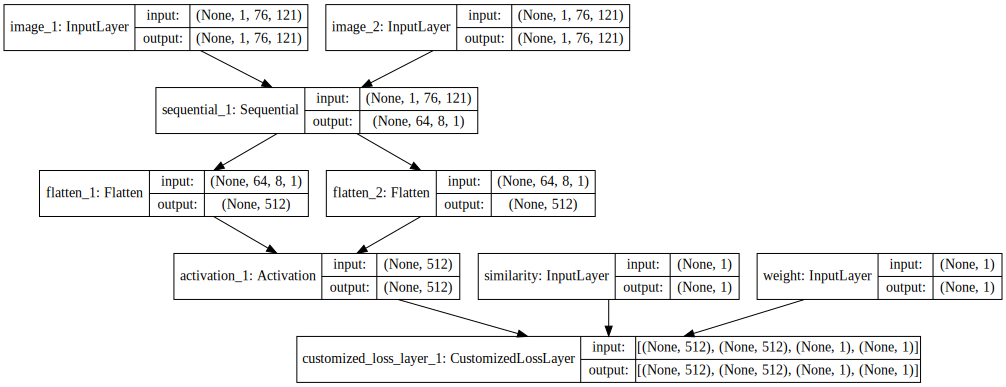

In [24]:
plot_model(model, show_shapes=True, to_file='model.png')
logger.debug("Save model architecture to model.png")
SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))

## Visualize performance before training

For the purpose of understanding the performance of this algorithm, we find the baseline result by computing the hamming distance between two representations before training and then plotting the corresponding histogram. Based on the above diagram, we use the representation at layers named `flatten_1` and `flatten_2`, before the fully connected layer defined by HashNet paper.

In [25]:
representation_model = Model(image_a, flatten_a)

In [26]:
def visualize(X1, X2, groundTruth, model):
    plt.figure()
    hist_sim = []
    hist_non_sim = []
    bins = np.linspace(0, 400, 100)

    pred_X1 = (model.predict(X1) > 0)
    pred_X2 = (model.predict(X2) > 0)
    for idx in range(len(X1)):
        score = np.count_nonzero(pred_X1[idx] != pred_X2[idx])
        similarity = (groundTruth[idx][0] == groundTruth[idx][1])

        if similarity:
            hist_sim.append(score)
        else:
            hist_non_sim.append(score)

    plt.ylim((0, 135))
    plt.ylabel("Count")
    plt.xlabel("$|x-y|$, e.g. Hamming distance")
    plt.hist(hist_sim, bins, alpha=0.5, label='Similar pairs', color='blue')
    plt.hist(hist_non_sim, bins, alpha=0.5, label='Non-similar pairs', color='orange')
    plt.legend()
    plt.show()

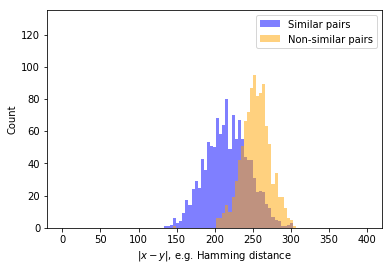

In [27]:
visualize(X1, X2, groundTruth, representation_model)

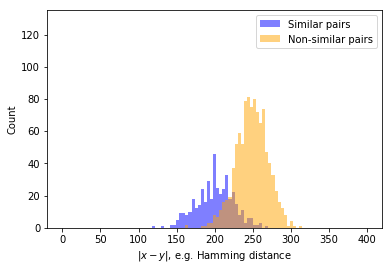

In [28]:
visualize(X1_val, X2_val, groundTruth_val, representation_model)

In [29]:
def visualizeFilters():
    nFilters = base_model.layers[0].get_weights()[0].shape[-1]
    plt.figure(figsize=(8,20))
    plt.tight_layout(pad=0, w_pad=0, h_pad=-10)
    for i in range(nFilters):
        filt = base_model.layers[0].get_weights()[0][:,:,0,i]
        plt.subplot(7, 10, i+1)
        plt.imshow(filt.T, cmap='jet')
        plt.xticks([])
        plt.yticks([])
    plt.show()

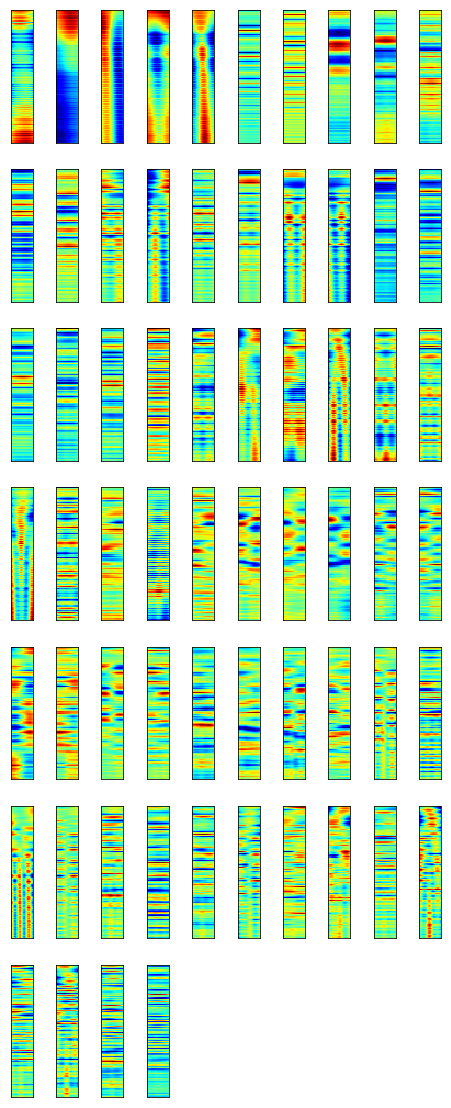

In [30]:
visualizeFilters()

## Train a model

In [31]:
# Check the input shape
logger.debug("Ready to train the model")
logger.debug("X1 shape: {:}".format(X1.shape))
logger.debug("X2 shape: {:}".format(X2.shape))
logger.debug("S shape: {:}".format(S.shape))
logger.debug("W shape: {:}".format(W.shape))

2018-03-07 01:18:46,339 - root - DEBUG - Ready to train the model
2018-03-07 01:18:46,340 - root - DEBUG - X1 shape: (2210, 1, 76, 121)
2018-03-07 01:18:46,341 - root - DEBUG - X2 shape: (2210, 1, 76, 121)
2018-03-07 01:18:46,342 - root - DEBUG - S shape: (2210, 1)
2018-03-07 01:18:46,343 - root - DEBUG - W shape: (2210, 1)


In [32]:
number_of_iterations = 100
logger.debug("[Training] number_of_iterations = {:}".format(number_of_iterations))
beta_factor = 1.5
logger.debug("[Training] beta_factor = {:}".format(beta_factor))
number_of_epochs = 200
logger.debug("[Training] number_of_epochs = {:}".format(number_of_epochs))

2018-03-07 01:18:46,350 - root - DEBUG - [Training] number_of_iterations = 100
2018-03-07 01:18:46,351 - root - DEBUG - [Training] beta_factor = 1.5
2018-03-07 01:18:46,352 - root - DEBUG - [Training] number_of_epochs = 200


In [ ]:
train_losses = []
test_losses = []

2018-03-07 01:18:46,376 - root - DEBUG - Iteration 1 (current beta = 1)


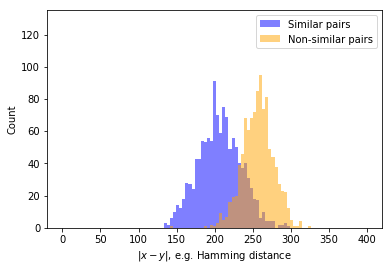

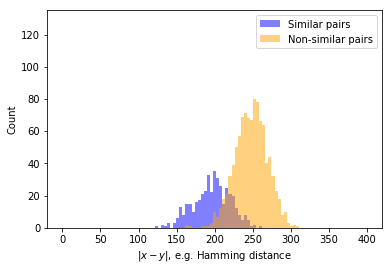

1424/1424 [==============================] - 0s 191us/step
2018-03-07 01:20:47,879 - root - DEBUG - [Iteration = 1] Training Loss = 34.249942780835596, Testing Loss = 45.91577368304971
2018-03-07 01:20:47,880 - root - DEBUG - Iteration 2 (current beta = 1.5)


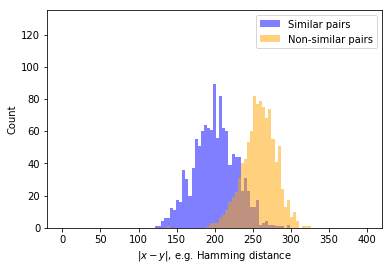

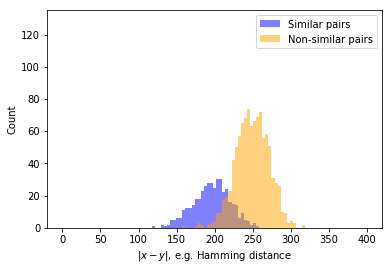

1424/1424 [==============================] - 0s 191us/step
2018-03-07 01:22:50,474 - root - DEBUG - [Iteration = 2] Training Loss = 31.21410057016088, Testing Loss = 43.889955171038594
2018-03-07 01:22:50,476 - root - DEBUG - Iteration 3 (current beta = 2.25)


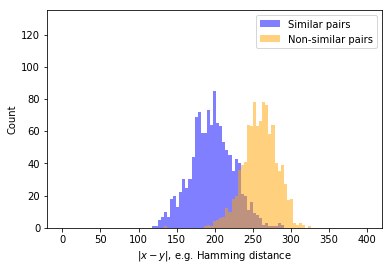

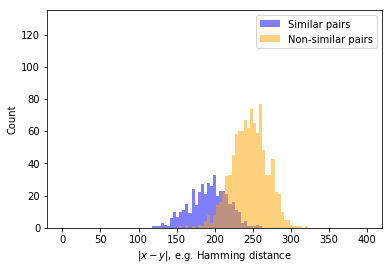

1424/1424 [==============================] - 0s 181us/step
2018-03-07 01:24:53,242 - root - DEBUG - [Iteration = 3] Training Loss = 30.912717215723582, Testing Loss = 51.86213114690245
2018-03-07 01:24:53,244 - root - DEBUG - Iteration 4 (current beta = 3.375)


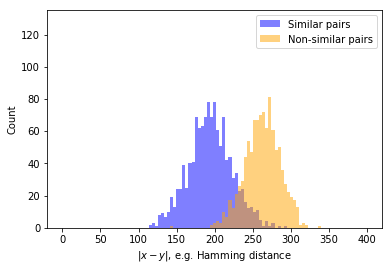

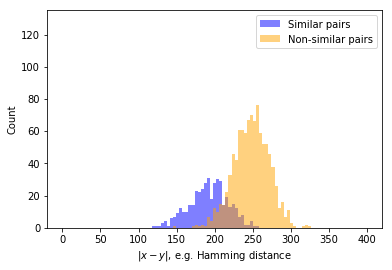

1424/1424 [==============================] - 0s 187us/step
2018-03-07 01:26:54,874 - root - DEBUG - [Iteration = 4] Training Loss = 27.437615549726186, Testing Loss = 48.05734628505921
2018-03-07 01:26:54,876 - root - DEBUG - Iteration 5 (current beta = 5.0625)


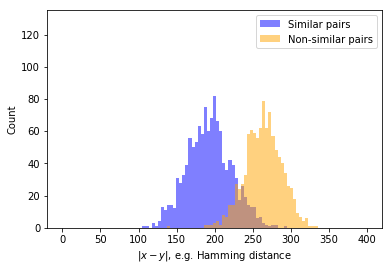

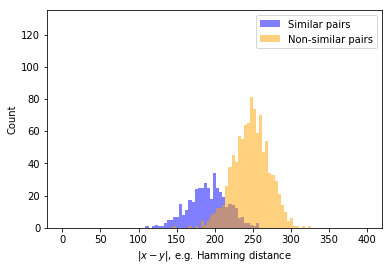

1424/1424 [==============================] - 0s 160us/step
2018-03-07 01:28:56,905 - root - DEBUG - [Iteration = 5] Training Loss = 27.067286258693194, Testing Loss = 48.68741623303863
2018-03-07 01:28:56,906 - root - DEBUG - Iteration 6 (current beta = 7.59375)


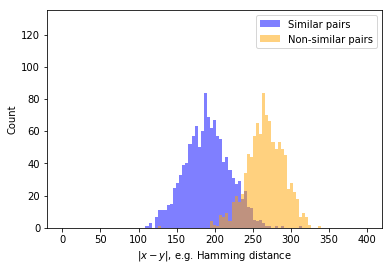

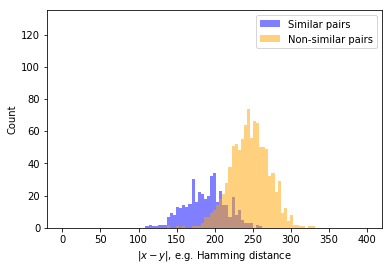

1424/1424 [==============================] - 0s 174us/step
2018-03-07 01:30:58,565 - root - DEBUG - [Iteration = 6] Training Loss = 24.03552904425703, Testing Loss = 54.034555521573914
2018-03-07 01:30:58,567 - root - DEBUG - Iteration 7 (current beta = 11.390625)


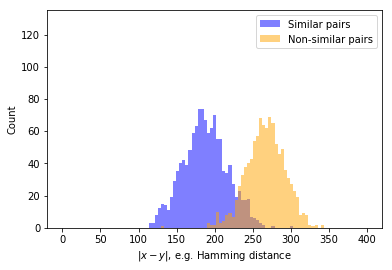

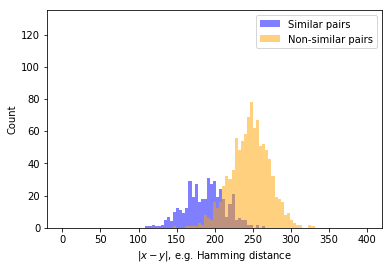

1424/1424 [==============================] - 0s 179us/step
2018-03-07 01:33:00,511 - root - DEBUG - [Iteration = 7] Training Loss = 24.349934196903696, Testing Loss = 52.84799339630631
2018-03-07 01:33:00,513 - root - DEBUG - Iteration 8 (current beta = 17.0859375)


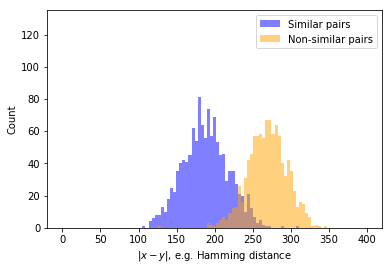

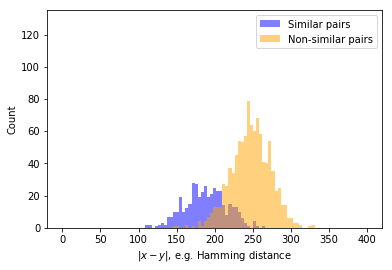

1424/1424 [==============================] - 0s 175us/step
2018-03-07 01:35:04,054 - root - DEBUG - [Iteration = 8] Training Loss = 22.1918974497739, Testing Loss = 51.72313318359718
2018-03-07 01:35:04,055 - root - DEBUG - Iteration 9 (current beta = 25.62890625)


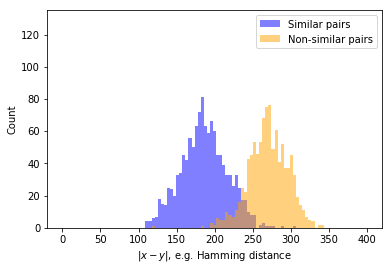

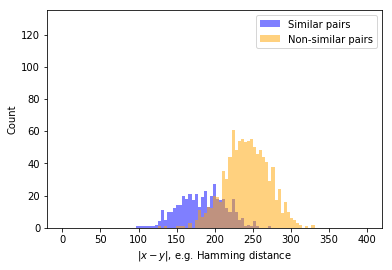

1424/1424 [==============================] - 0s 180us/step
2018-03-07 01:37:05,771 - root - DEBUG - [Iteration = 9] Training Loss = 21.65569125896665, Testing Loss = 64.55539771596368
2018-03-07 01:37:05,772 - root - DEBUG - Iteration 10 (current beta = 38.443359375)


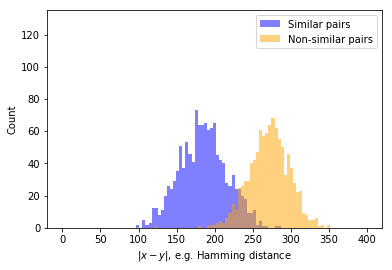

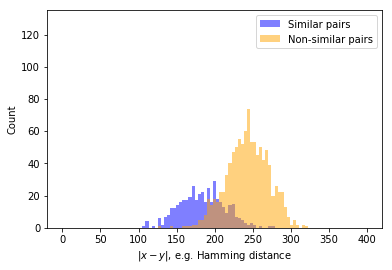

1424/1424 [==============================] - 0s 159us/step
2018-03-07 01:39:06,912 - root - DEBUG - [Iteration = 10] Training Loss = 21.235932763264728, Testing Loss = 61.2382439411758
2018-03-07 01:39:06,913 - root - DEBUG - Iteration 11 (current beta = 57.6650390625)


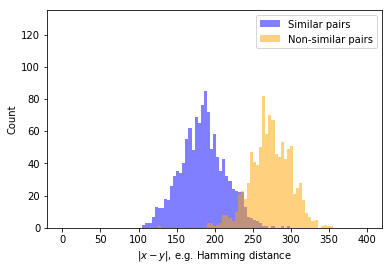

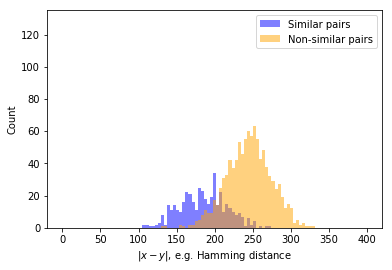

1424/1424 [==============================] - 0s 176us/step
2018-03-07 01:41:06,618 - root - DEBUG - [Iteration = 11] Training Loss = 19.356003951891516, Testing Loss = 60.042935400196676
2018-03-07 01:41:06,619 - root - DEBUG - Iteration 12 (current beta = 86.49755859375)


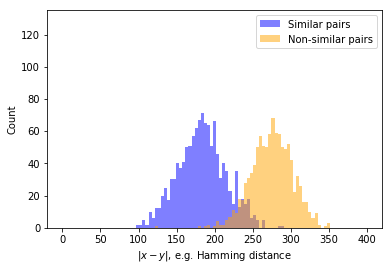

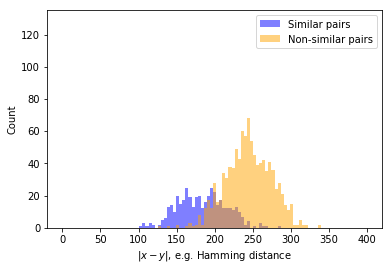

1424/1424 [==============================] - 0s 176us/step
2018-03-07 01:43:06,735 - root - DEBUG - [Iteration = 12] Training Loss = 18.775362742001114, Testing Loss = 62.09392669834615
2018-03-07 01:43:06,736 - root - DEBUG - Iteration 13 (current beta = 129.746337890625)


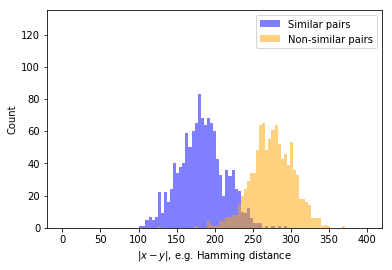

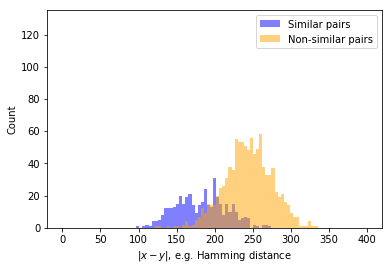

1424/1424 [==============================] - 0s 147us/step
2018-03-07 01:45:07,320 - root - DEBUG - [Iteration = 13] Training Loss = 18.44455964942863, Testing Loss = 64.99975412627786
2018-03-07 01:45:07,321 - root - DEBUG - Iteration 14 (current beta = 194.6195068359375)


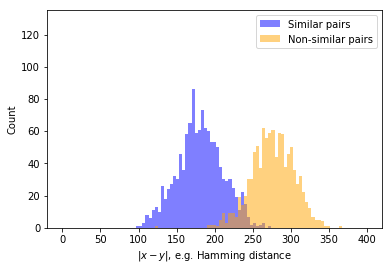

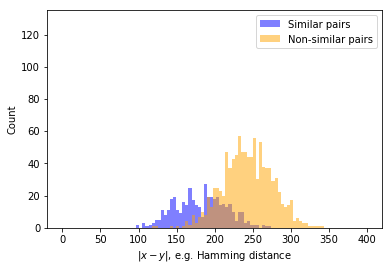

1424/1424 [==============================] - 0s 186us/step
2018-03-07 01:47:07,171 - root - DEBUG - [Iteration = 14] Training Loss = 18.035298907702863, Testing Loss = 67.93313399769282
2018-03-07 01:47:07,173 - root - DEBUG - Iteration 15 (current beta = 291.92926025390625)


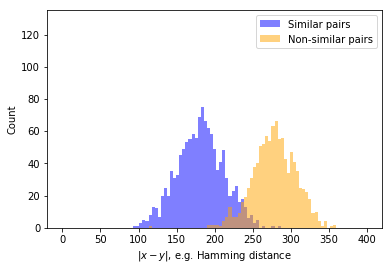

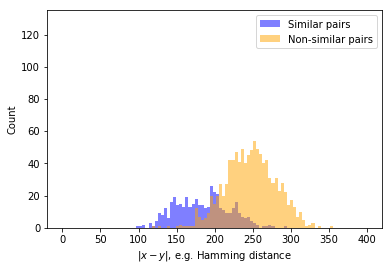

1424/1424 [==============================] - 0s 176us/step
2018-03-07 01:49:07,079 - root - DEBUG - [Iteration = 15] Training Loss = 16.428056969672305, Testing Loss = 61.79783135066541
2018-03-07 01:49:07,081 - root - DEBUG - Iteration 16 (current beta = 437.8938903808594)


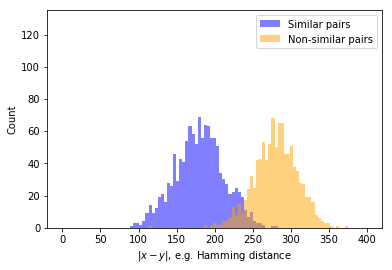

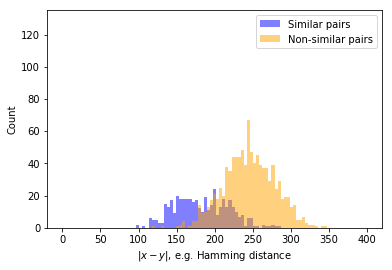

1424/1424 [==============================] - 0s 181us/step
2018-03-07 01:51:08,871 - root - DEBUG - [Iteration = 16] Training Loss = 15.51729333384544, Testing Loss = 65.80687522406826
2018-03-07 01:51:08,872 - root - DEBUG - Iteration 17 (current beta = 656.8408355712891)


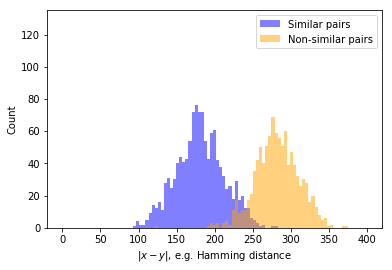

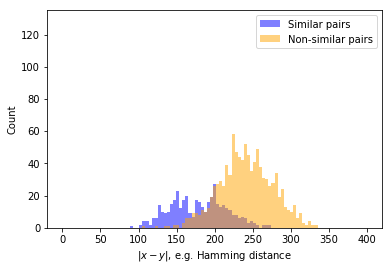

1424/1424 [==============================] - 0s 179us/step
2018-03-07 01:53:09,178 - root - DEBUG - [Iteration = 17] Training Loss = 14.666763563285587, Testing Loss = 74.93483180477378
2018-03-07 01:53:09,180 - root - DEBUG - Iteration 18 (current beta = 985.2612533569336)


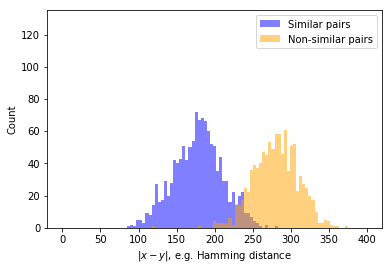

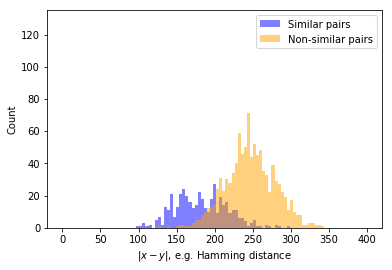

1424/1424 [==============================] - 0s 169us/step
2018-03-07 01:55:08,138 - root - DEBUG - [Iteration = 18] Training Loss = 15.87457920120043, Testing Loss = 62.18699881936727
2018-03-07 01:55:08,139 - root - DEBUG - Iteration 19 (current beta = 1477.8918800354004)


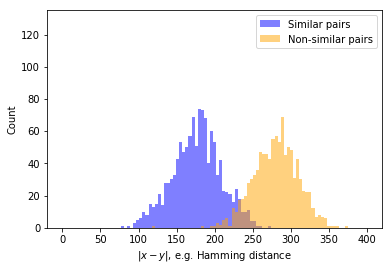

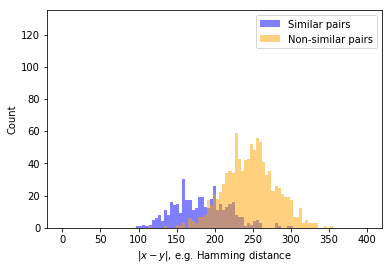

1424/1424 [==============================] - 0s 147us/step
2018-03-07 01:57:08,738 - root - DEBUG - [Iteration = 19] Training Loss = 15.82468832891721, Testing Loss = 63.71919470410166
2018-03-07 01:57:08,739 - root - DEBUG - Iteration 20 (current beta = 2216.8378200531006)


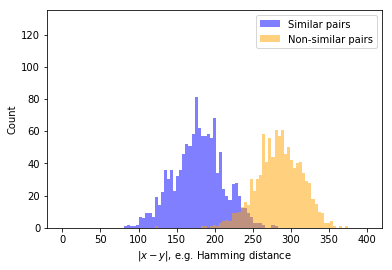

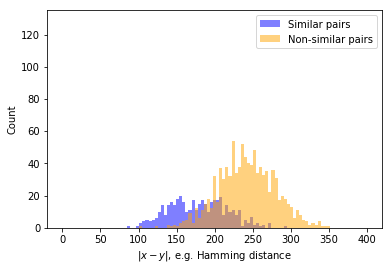

1424/1424 [==============================] - 0s 178us/step
2018-03-07 01:59:08,638 - root - DEBUG - [Iteration = 20] Training Loss = 13.955702043887717, Testing Loss = 76.33256887987758
2018-03-07 01:59:08,640 - root - DEBUG - Iteration 21 (current beta = 3325.256730079651)


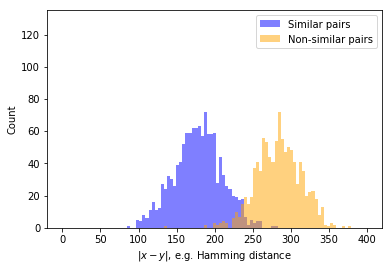

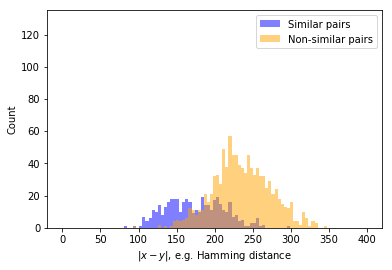

1424/1424 [==============================] - 0s 182us/step
2018-03-07 02:01:08,658 - root - DEBUG - [Iteration = 21] Training Loss = 13.460600975951458, Testing Loss = 89.01407396697094
2018-03-07 02:01:08,659 - root - DEBUG - Iteration 22 (current beta = 4987.885095119476)


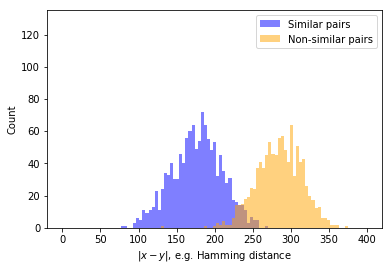

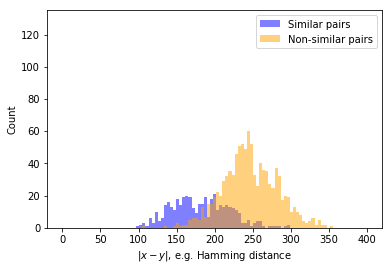

1424/1424 [==============================] - 0s 189us/step
2018-03-07 02:03:08,531 - root - DEBUG - [Iteration = 22] Training Loss = 13.499592804183923, Testing Loss = 67.91887380467372
2018-03-07 02:03:08,533 - root - DEBUG - Iteration 23 (current beta = 7481.8276426792145)


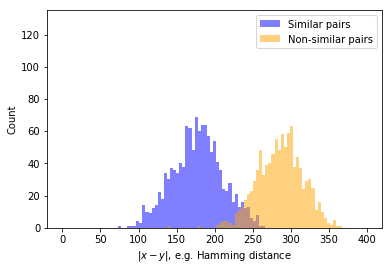

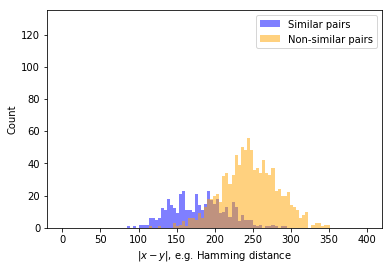

1424/1424 [==============================] - 0s 182us/step
2018-03-07 02:05:08,311 - root - DEBUG - [Iteration = 23] Training Loss = 12.686736003481425, Testing Loss = 67.86295323911008
2018-03-07 02:05:08,313 - root - DEBUG - Iteration 24 (current beta = 11222.741464018822)


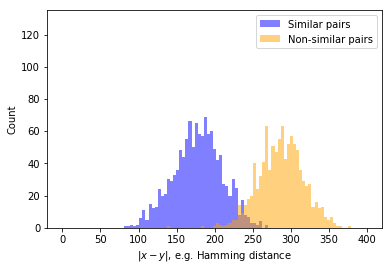

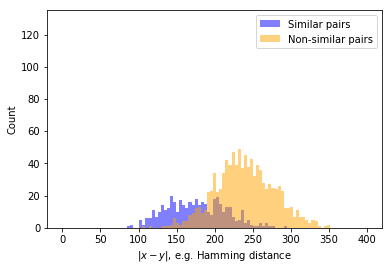

1424/1424 [==============================] - 0s 174us/step
2018-03-07 02:07:08,005 - root - DEBUG - [Iteration = 24] Training Loss = 11.762416778150861, Testing Loss = 83.52185831947273
2018-03-07 02:07:08,006 - root - DEBUG - Iteration 25 (current beta = 16834.112196028233)


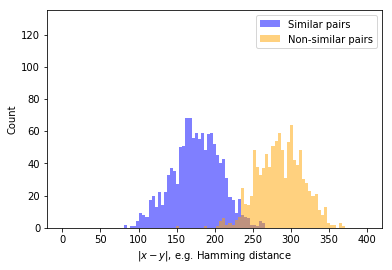

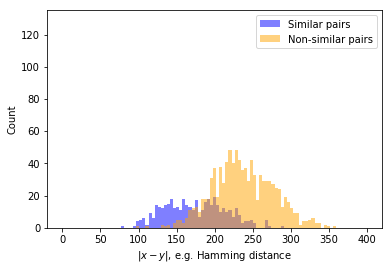

1424/1424 [==============================] - 0s 195us/step
2018-03-07 02:09:07,924 - root - DEBUG - [Iteration = 25] Training Loss = 12.486084354571087, Testing Loss = 89.63277109306347
2018-03-07 02:09:07,925 - root - DEBUG - Iteration 26 (current beta = 25251.16829404235)


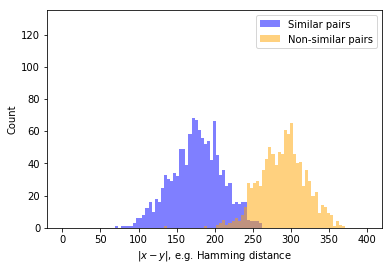

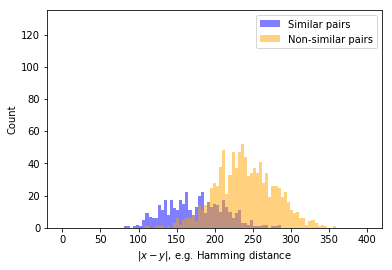

1424/1424 [==============================] - 0s 173us/step
2018-03-07 02:11:08,025 - root - DEBUG - [Iteration = 26] Training Loss = 11.172749132133717, Testing Loss = 81.38626604250977
2018-03-07 02:11:08,026 - root - DEBUG - Iteration 27 (current beta = 37876.75244106352)


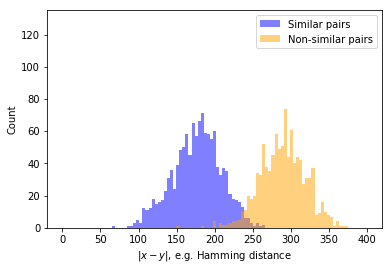

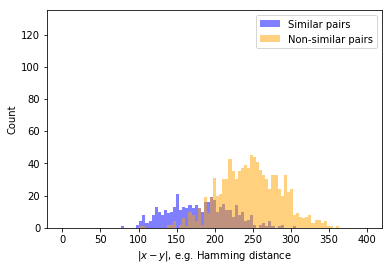

1424/1424 [==============================] - 0s 175us/step
2018-03-07 02:13:07,366 - root - DEBUG - [Iteration = 27] Training Loss = 10.502543435117643, Testing Loss = 71.20819874811039
2018-03-07 02:13:07,367 - root - DEBUG - Iteration 28 (current beta = 56815.128661595285)


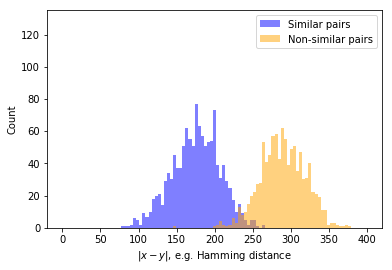

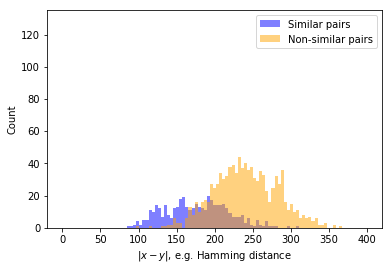

1424/1424 [==============================] - 0s 171us/step
2018-03-07 02:15:06,261 - root - DEBUG - [Iteration = 28] Training Loss = 10.309831340327792, Testing Loss = 84.22905936447924
2018-03-07 02:15:06,262 - root - DEBUG - Iteration 29 (current beta = 85222.69299239293)


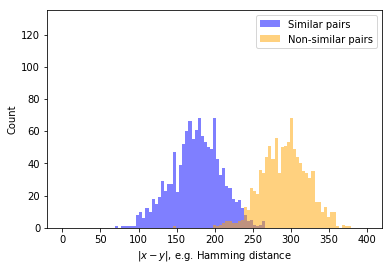

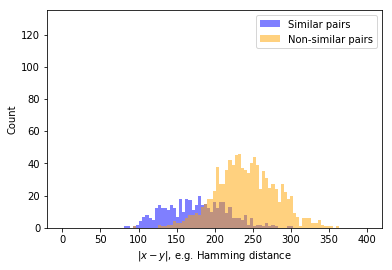

1424/1424 [==============================] - 0s 180us/step
2018-03-07 02:17:05,598 - root - DEBUG - [Iteration = 29] Training Loss = 9.5594945447511, Testing Loss = 81.98611447683881
2018-03-07 02:17:05,600 - root - DEBUG - Iteration 30 (current beta = 127834.03948858939)


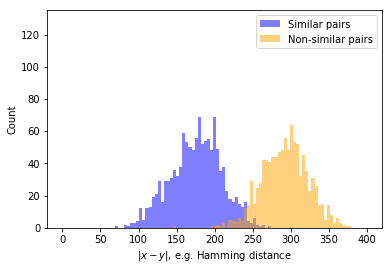

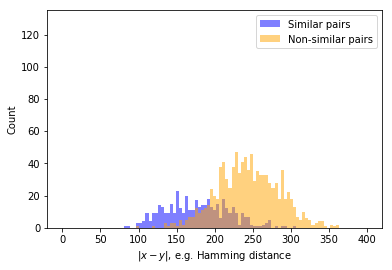

1424/1424 [==============================] - 0s 196us/step
2018-03-07 02:19:07,257 - root - DEBUG - [Iteration = 30] Training Loss = 9.445465638732951, Testing Loss = 77.71308666501153
2018-03-07 02:19:07,259 - root - DEBUG - Iteration 31 (current beta = 191751.0592328841)


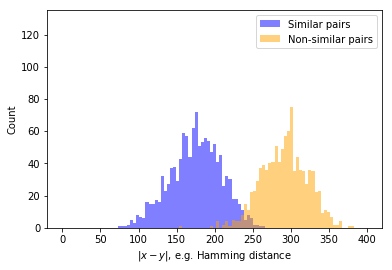

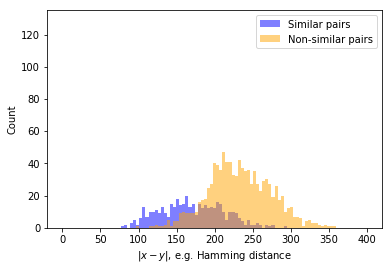

1424/1424 [==============================] - 0s 171us/step
2018-03-07 02:21:07,532 - root - DEBUG - [Iteration = 31] Training Loss = 9.682757118748864, Testing Loss = 100.44508477266919
2018-03-07 02:21:07,533 - root - DEBUG - Iteration 32 (current beta = 287626.58884932613)


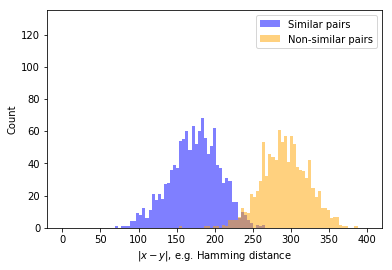

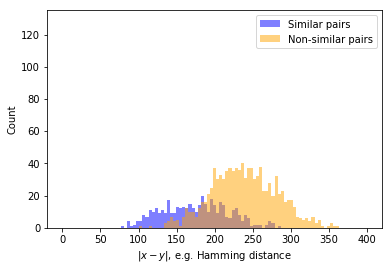

1424/1424 [==============================] - 0s 183us/step
2018-03-07 02:23:08,008 - root - DEBUG - [Iteration = 32] Training Loss = 9.53979901858854, Testing Loss = 90.95748228244902
2018-03-07 02:23:08,009 - root - DEBUG - Iteration 33 (current beta = 431439.8832739892)


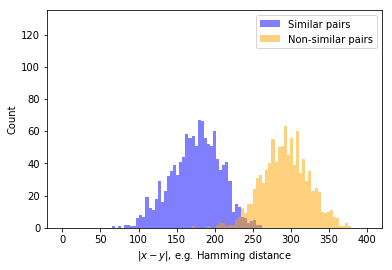

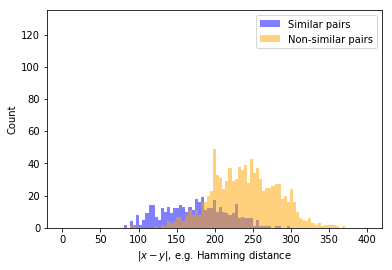

1424/1424 [==============================] - 0s 178us/step
2018-03-07 02:25:08,778 - root - DEBUG - [Iteration = 33] Training Loss = 9.502778864328274, Testing Loss = 89.1427789784633
2018-03-07 02:25:08,780 - root - DEBUG - Iteration 34 (current beta = 647159.8249109838)


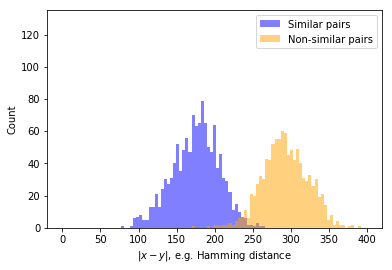

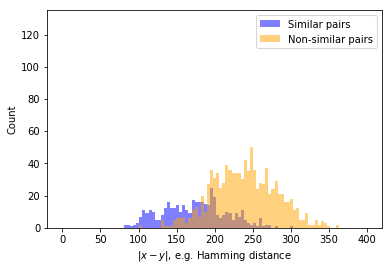

1424/1424 [==============================] - 0s 178us/step
2018-03-07 02:27:09,704 - root - DEBUG - [Iteration = 34] Training Loss = 8.670394412151694, Testing Loss = 88.86934969791871
2018-03-07 02:27:09,705 - root - DEBUG - Iteration 35 (current beta = 970739.7373664756)


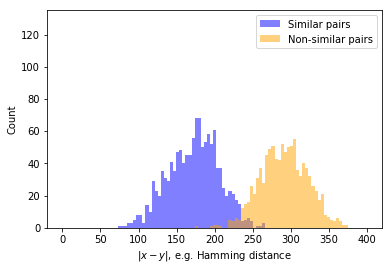

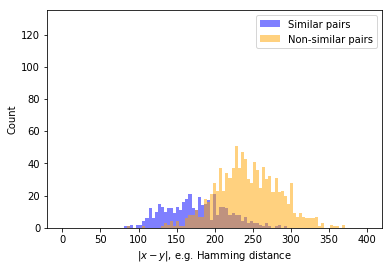

1424/1424 [==============================] - 0s 198us/step
2018-03-07 02:29:10,235 - root - DEBUG - [Iteration = 35] Training Loss = 10.01770770974137, Testing Loss = 78.39328017303448
2018-03-07 02:29:10,236 - root - DEBUG - Iteration 36 (current beta = 1456109.6060497134)


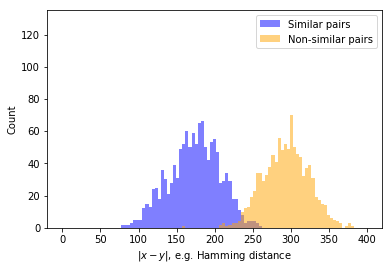

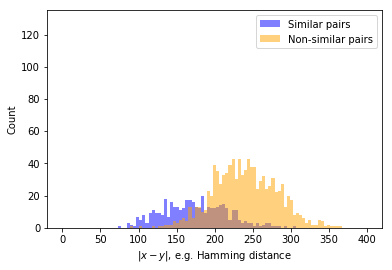

1424/1424 [==============================] - 0s 181us/step
2018-03-07 02:31:10,265 - root - DEBUG - [Iteration = 36] Training Loss = 8.462373667518815, Testing Loss = 88.04242008246398
2018-03-07 02:31:10,267 - root - DEBUG - Iteration 37 (current beta = 2184164.40907457)


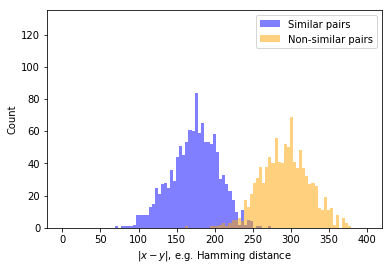

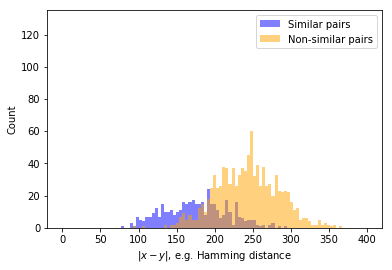

1424/1424 [==============================] - 0s 144us/step
2018-03-07 02:33:09,442 - root - DEBUG - [Iteration = 37] Training Loss = 9.618075110166592, Testing Loss = 80.31537297317821
2018-03-07 02:33:09,443 - root - DEBUG - Iteration 38 (current beta = 3276246.613611855)


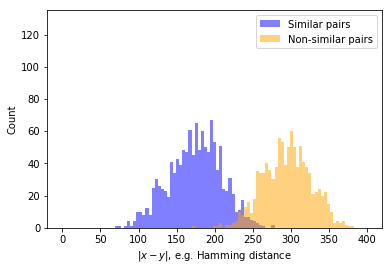

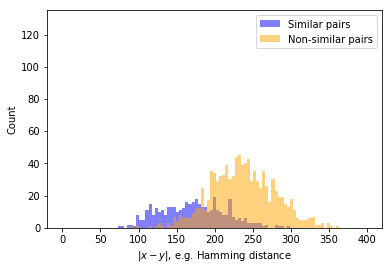

1424/1424 [==============================] - 0s 181us/step
2018-03-07 02:35:09,840 - root - DEBUG - [Iteration = 38] Training Loss = 8.90451187085849, Testing Loss = 93.09522927581762
2018-03-07 02:35:09,841 - root - DEBUG - Iteration 39 (current beta = 4914369.920417783)


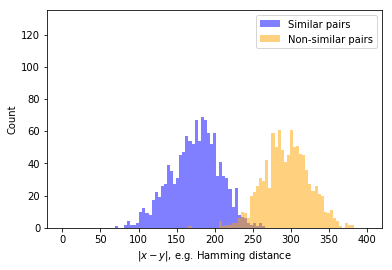

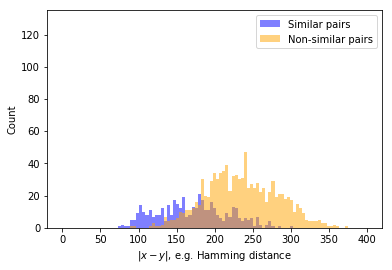

1424/1424 [==============================] - 0s 184us/step
2018-03-07 02:37:10,418 - root - DEBUG - [Iteration = 39] Training Loss = 8.148252627240048, Testing Loss = 104.34429029540651
2018-03-07 02:37:10,419 - root - DEBUG - Iteration 40 (current beta = 7371554.880626675)


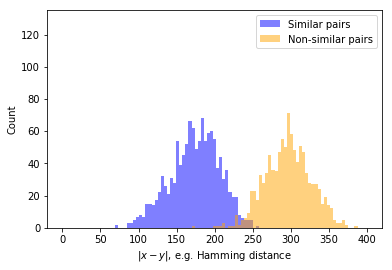

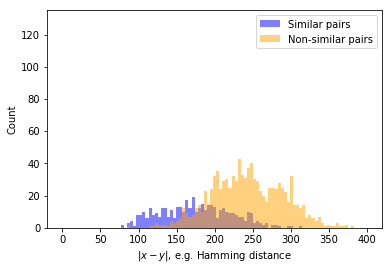

1424/1424 [==============================] - 0s 224us/step
2018-03-07 02:39:09,441 - root - DEBUG - [Iteration = 40] Training Loss = 7.22011115830476, Testing Loss = 88.66381296821022
2018-03-07 02:39:09,443 - root - DEBUG - Iteration 41 (current beta = 11057332.320940012)


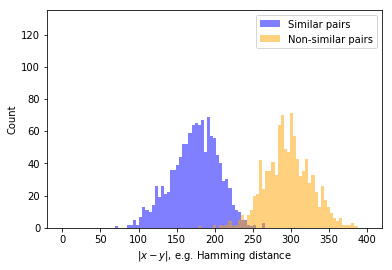

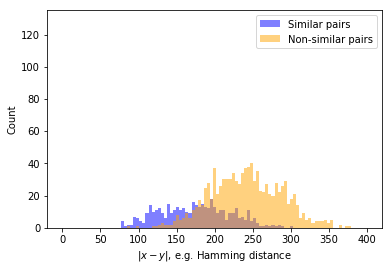

1424/1424 [==============================] - 0s 178us/step
2018-03-07 02:41:09,035 - root - DEBUG - [Iteration = 41] Training Loss = 7.184680276451742, Testing Loss = 90.50251363081794
2018-03-07 02:41:09,036 - root - DEBUG - Iteration 42 (current beta = 16585998.48141002)


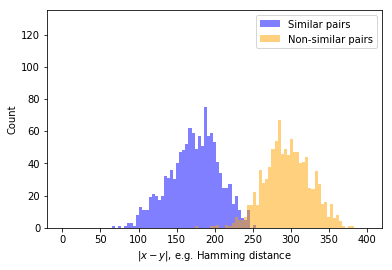

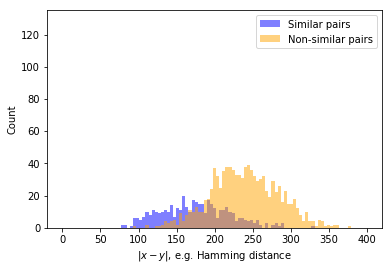

1424/1424 [==============================] - 0s 179us/step
2018-03-07 02:43:09,876 - root - DEBUG - [Iteration = 42] Training Loss = 7.678138539970461, Testing Loss = 92.07778564154097
2018-03-07 02:43:09,877 - root - DEBUG - Iteration 43 (current beta = 24878997.72211503)


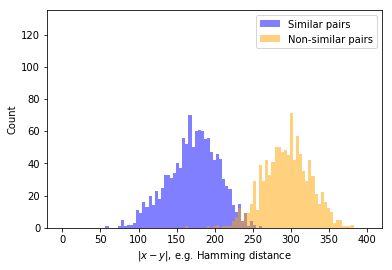

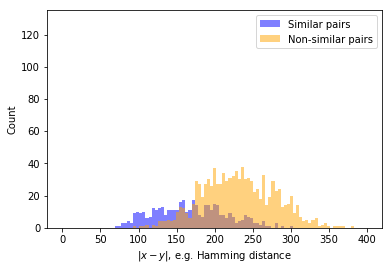

1424/1424 [==============================] - 0s 186us/step
2018-03-07 02:45:10,350 - root - DEBUG - [Iteration = 43] Training Loss = 8.386664013008321, Testing Loss = 112.90312373197607
2018-03-07 02:45:10,352 - root - DEBUG - Iteration 44 (current beta = 37318496.583172545)


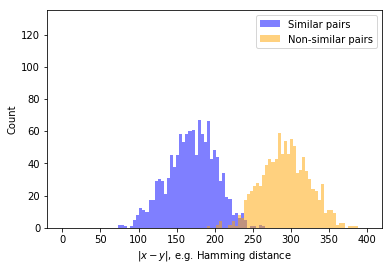

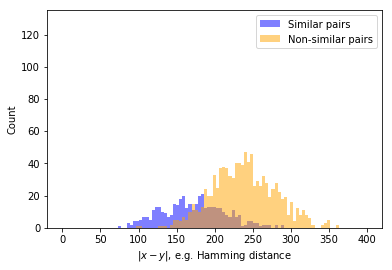

1424/1424 [==============================] - 0s 161us/step
2018-03-07 02:47:06,248 - root - DEBUG - [Iteration = 44] Training Loss = 9.007960237807076, Testing Loss = 89.9657009857173
2018-03-07 02:47:06,249 - root - DEBUG - Iteration 45 (current beta = 55977744.87475882)


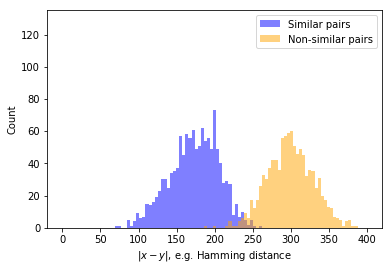

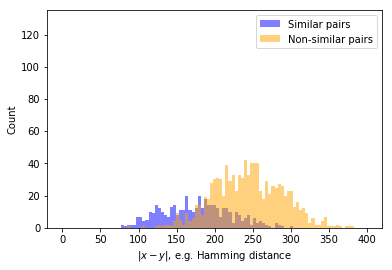

1424/1424 [==============================] - 0s 162us/step
2018-03-07 02:48:54,800 - root - DEBUG - [Iteration = 45] Training Loss = 5.929138274649285, Testing Loss = 84.693707410581
2018-03-07 02:48:54,801 - root - DEBUG - Iteration 46 (current beta = 83966617.31213823)


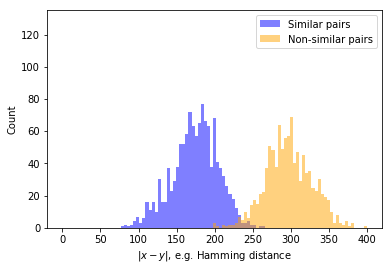

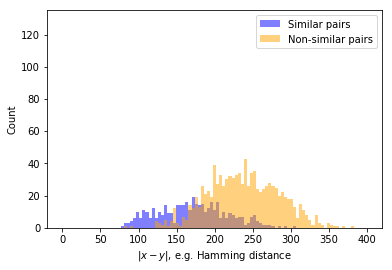

1424/1424 [==============================] - 0s 151us/step
2018-03-07 02:50:42,819 - root - DEBUG - [Iteration = 46] Training Loss = 6.7005094927428, Testing Loss = 97.94195397116579
2018-03-07 02:50:42,820 - root - DEBUG - Iteration 47 (current beta = 125949925.96820734)


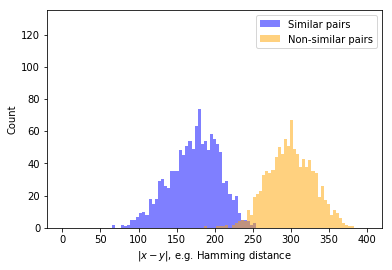

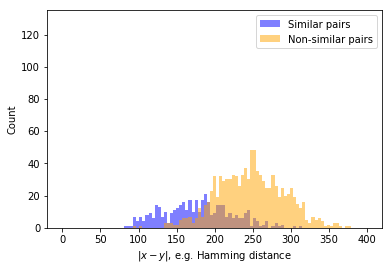

1424/1424 [==============================] - 0s 154us/step
2018-03-07 02:52:29,645 - root - DEBUG - [Iteration = 47] Training Loss = 5.99750089737928, Testing Loss = 76.9101901808649
2018-03-07 02:52:29,646 - root - DEBUG - Iteration 48 (current beta = 188924888.952311)


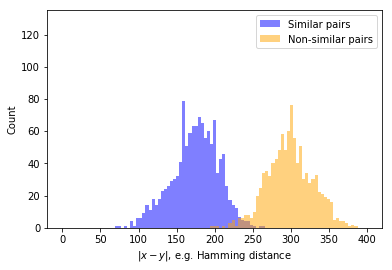

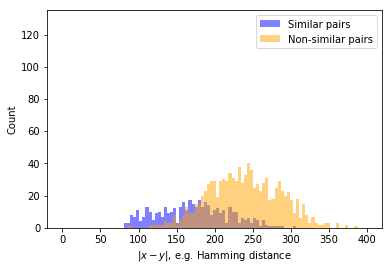

1424/1424 [==============================] - 0s 181us/step
2018-03-07 02:54:24,562 - root - DEBUG - [Iteration = 48] Training Loss = 6.026604697657791, Testing Loss = 97.12895345821809
2018-03-07 02:54:24,564 - root - DEBUG - Iteration 49 (current beta = 283387333.4284665)


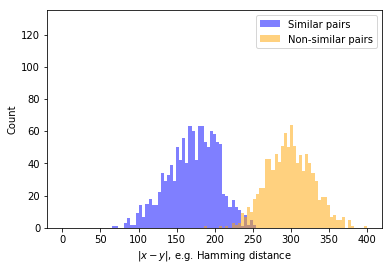

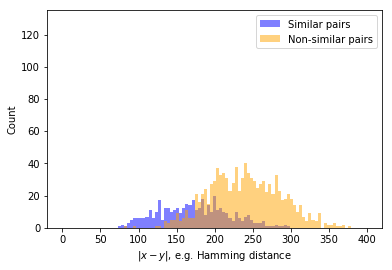

1424/1424 [==============================] - 0s 168us/step
2018-03-07 02:56:25,241 - root - DEBUG - [Iteration = 49] Training Loss = 6.239050212660088, Testing Loss = 95.3298280866126
2018-03-07 02:56:25,242 - root - DEBUG - Iteration 50 (current beta = 425081000.1426997)


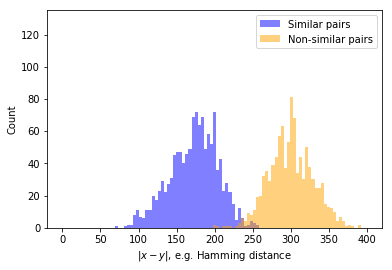

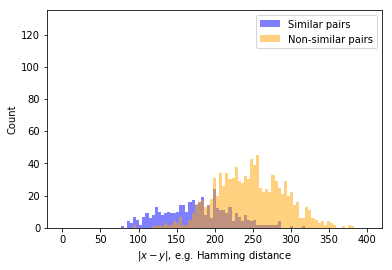

1424/1424 [==============================] - 0s 205us/step
2018-03-07 02:58:32,153 - root - DEBUG - [Iteration = 50] Training Loss = 5.157578387364273, Testing Loss = 82.24063546185413
2018-03-07 02:58:32,153 - root - DEBUG - Iteration 51 (current beta = 637621500.2140496)


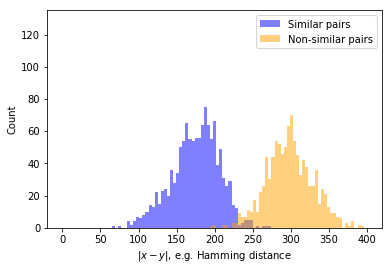

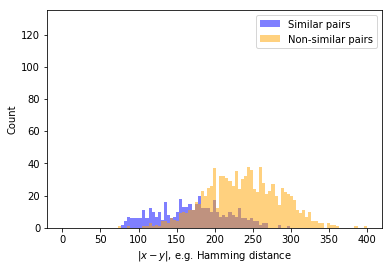

1424/1424 [==============================] - 0s 211us/step
2018-03-07 03:00:43,935 - root - DEBUG - [Iteration = 51] Training Loss = 6.785097973343676, Testing Loss = 99.55734990137431
2018-03-07 03:00:43,936 - root - DEBUG - Iteration 52 (current beta = 956432250.3210744)


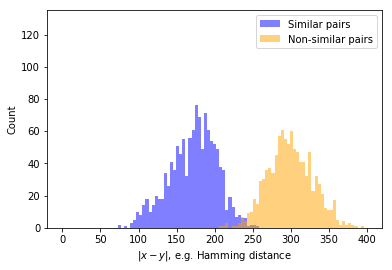

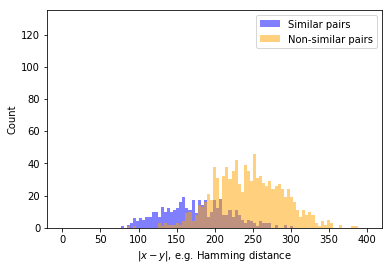

1424/1424 [==============================] - 0s 204us/step
2018-03-07 03:02:53,194 - root - DEBUG - [Iteration = 52] Training Loss = 5.384682351086137, Testing Loss = 82.41657549544666
2018-03-07 03:02:53,194 - root - DEBUG - Iteration 53 (current beta = 1434648375.4816115)


In [ ]:
for m in range(1, number_of_iterations+1):
    logger.debug("Iteration {:} (current beta = {:})".format(m, beta))
    
    # Train a model with 4 inputs and 1 dummy output.
    model.fit({'image_1': X1, 'image_2': X2, 'similarity': S, 'weight': W}, [S], verbose=verbose, epochs=number_of_epochs)
    beta *= beta_factor
    
    representation_model = Model(image_a, encoded_a)
    visualize(X1, X2, groundTruth, representation_model)
    visualize(X1_val, X2_val, groundTruth_val, representation_model)
#     visualizeFilters()
    
    train_loss = model.evaluate({'image_1': X1, 'image_2': X2, 'similarity': S, 'weight': W}, [S])
    test_loss  = model.evaluate({'image_1': X1_val, 'image_2': X2_val, 'similarity': S_val, 'weight': W_val}, [S_val])
    logger.debug("[Iteration = {:}] Training Loss = {:}, Testing Loss = {:}".format(m, train_loss, test_loss))
    train_losses.append(train_loss)
    test_losses.append(test_loss)

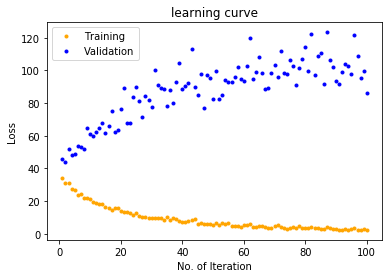

In [42]:
plt.figure()
plt.title("learning curve")
plt.plot(range(1,len(train_losses)+1), train_losses, '.', color='orange', label='Training')
plt.plot(range(1,len(test_losses)+1), test_losses, '.', color='blue', label='Validation')
plt.legend()
plt.ylabel("Loss")
plt.xlabel("No. of Iteration")
plt.show()

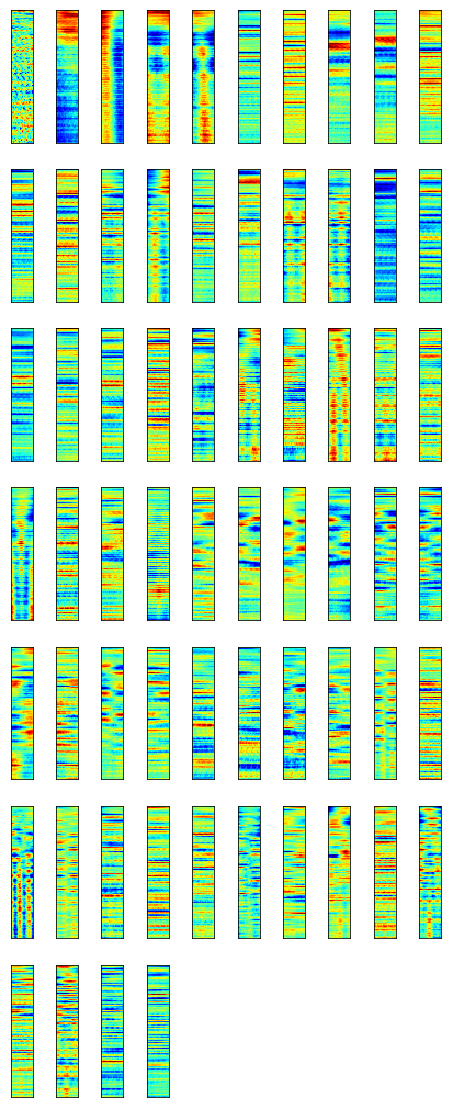

In [43]:
visualizeFilters()

## Save Model

In [ ]:
MODEL_NAME = str(datetime.date.today()) + EXPERIMENT_NAME + "[Iteration={:}]".format(number_of_iterations)
logger.debug("Save model to {:}.h5".format(MODEL_NAME))
model.save(MODEL_NAME + ".h5")

## Visualize Performance 

__Obtain a representation model__

This representation model is the same as the trained model above without the loss layer at the very end.

In [46]:
representation_model = Model(image_a, encoded_a)

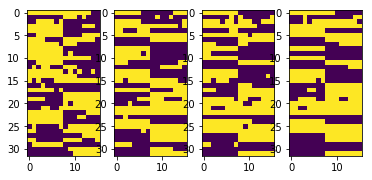

In [47]:
# Get sample output
# Reshaped to be (32,16) for visualization purposes.
pred_X1 = representation_model.predict(X1)
plt.subplot(1,4,1)
plt.imshow(pred_X1[:1].reshape(32,16) > 0)
plt.subplot(1,4,2)
plt.imshow(pred_X1[1:2].reshape(32,16) > 0)
plt.subplot(1,4,3)
plt.imshow(pred_X1[2:3].reshape(32,16) > 0)
plt.subplot(1,4,4)
plt.imshow(pred_X1[3:4].reshape(32,16) > 0)
plt.show()

## Evaluate Performance
Calculate the hamming distance input pairs and plot the corresponding histogram.

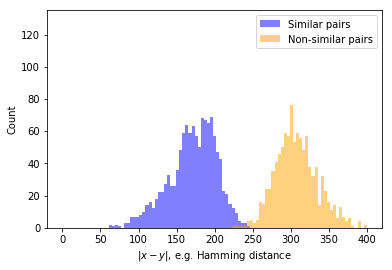

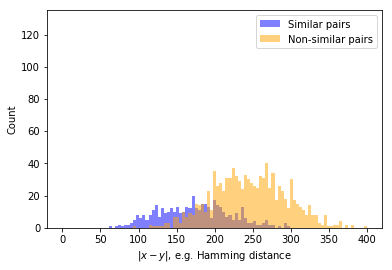

In [49]:
representation_model = Model(image_a, encoded_a)
visualize(X1, X2, groundTruth, representation_model)
visualize(X1_val, X2_val, groundTruth_val, representation_model)

## Appendix: Architecture Details

In [ ]:
model.summary()

In [ ]:
base_model.summary()